# dataset 

In [1]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [2]:
data_dir = "~/data/cityscapes/"
model_weights_dir = "./weights/"
model_checkpoints_dir = "./checkpoints/"
tensorboard_logger_dir = "./tb_logs/"


dataset = Cityscapes(data_dir, split='train', mode='fine',
                      target_type='semantic')

In [3]:
dataset[0][0].size

(2048, 1024)

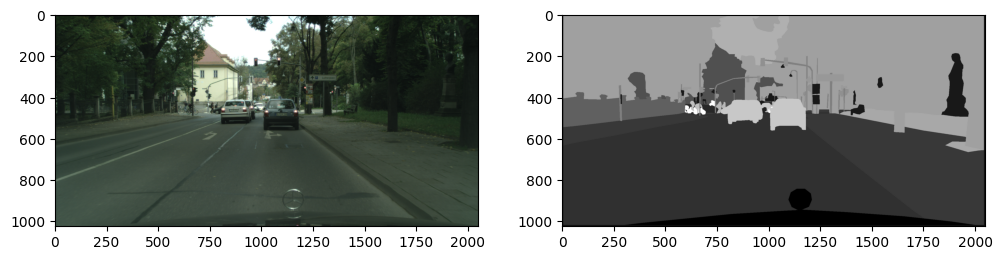

In [4]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

# some utility functions

In [5]:
#label understanding
#https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#function credits: https://github.com/meetps/pytorch-semseg/tree/master/ptsemseg

In [6]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [7]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))
label_colours

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [70, 70, 70],
 4: [102, 102, 156],
 5: [190, 153, 153],
 6: [153, 153, 153],
 7: [250, 170, 30],
 8: [220, 220, 0],
 9: [107, 142, 35],
 10: [152, 251, 152],
 11: [0, 130, 180],
 12: [220, 20, 60],
 13: [255, 0, 0],
 14: [0, 0, 142],
 15: [0, 0, 70],
 16: [0, 60, 100],
 17: [0, 80, 100],
 18: [0, 0, 230],
 19: [119, 11, 32]}

In [8]:
def encode_segmap(mask):
    #remove unwanted classes and rectify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [9]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)


In [11]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)
    


In [12]:
dataset=MyClass(data_dir, split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


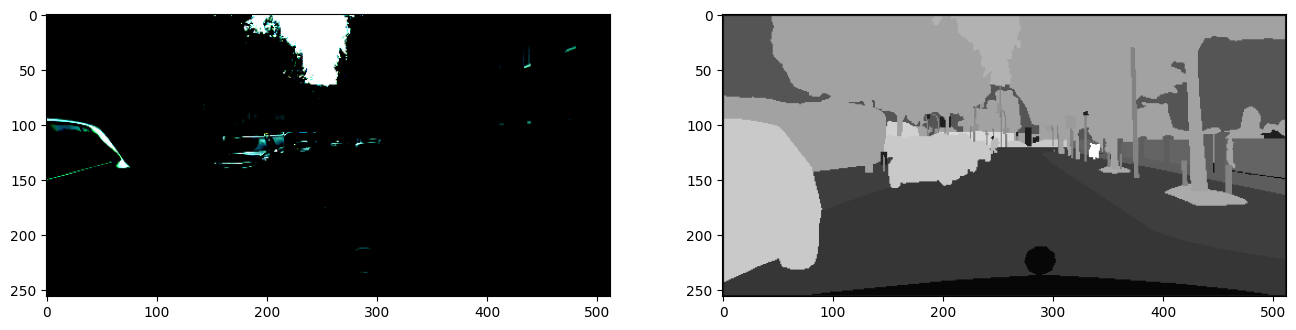

In [13]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [14]:
#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 0,  1,  3,  4,  6,  7,  8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 26,
        27, 28, 33], dtype=torch.uint8)
21


In [15]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))


torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19],
       dtype=torch.uint8)
17


In [16]:
#let do coloring
res1=decode_segmap(res.clone())


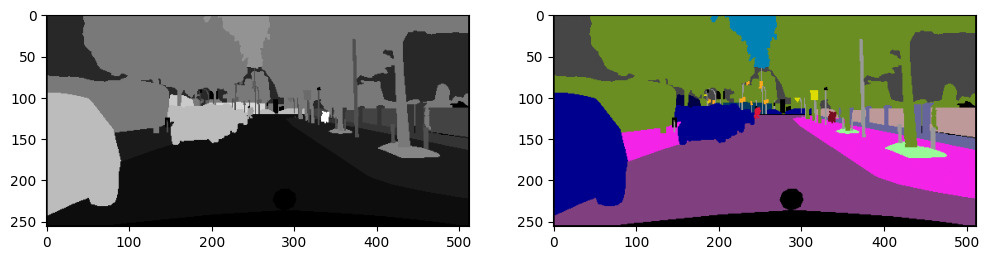

In [17]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

# training

In [19]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
import segmentation_models_pytorch as smp
from pytorch_lightning import seed_everything, LightningModule, Trainer
from lightning.pytorch.loggers import TensorBoardLogger
import multiprocessing
import torchmetrics
import torch

# for reproducibility
seed_everything(42, workers=True)

Seed set to 42


42

In [20]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=n_classes,                      # model output channels (number of classes in your dataset)
            )

    #parameters
    self.lr=1e-3
    self.batch_size=4
    self.numworker=multiprocessing.cpu_count()//4

    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes)
    
    self.train_class = MyClass(data_dir, split='train', mode='fine',
                      target_type='semantic',transforms=transform)
    self.val_class = MyClass(data_dir, split='val', mode='fine',
                      target_type='semantic',transforms=transform)
    
    
  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    jaccard=self.metrics(out,segment)
    return loss,jaccard
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,jaccard=self.process(image,segment)
    self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
    self.log('train_jaccard', jaccard,on_step=False, on_epoch=True,prog_bar=False)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,num_workers=self.numworker,pin_memory=True)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,jaccard=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_jaccard', jaccard,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [21]:
resume_training = True

model = OurModel()

if resume_training: 
    model.load_state_dict(torch.load(model_weights_dir+'model.pth'))

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                        dirpath=model_checkpoints_dir,
                                        filename='checkpoint_file',
                                        save_last=True)

In [22]:
# trainer = Trainer(max_epochs=200, auto_lr_find=False, auto_scale_batch_size=False,
#                   gpus=-1,precision=16,
#                   callbacks=[checkpoint_callback],
#                  )

logger = TensorBoardLogger(save_dir=tensorboard_logger_dir, name="semantic_segmentation_cityscapes")

trainer = Trainer(max_epochs = 5,
                    callbacks=[checkpoint_callback],
                    logger = logger,
                    deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model)
torch.save(model.state_dict(), model_weights_dir+'model.pth')

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-04-11 12:43:27.393561: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 12:43:27.416968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [24]:
model.load_state_dict(torch.load(model_weights_dir+'model.pth'))

<All keys matched successfully>

In [25]:
test_class = MyClass(data_dir, split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=12, 
                      shuffle=False)

In [26]:
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break
print(img.shape,seg.shape,output.shape)    

torch.Size([12, 3, 256, 512]) torch.Size([12, 256, 512]) torch.Size([12, 20, 256, 512])


In [27]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted mask')

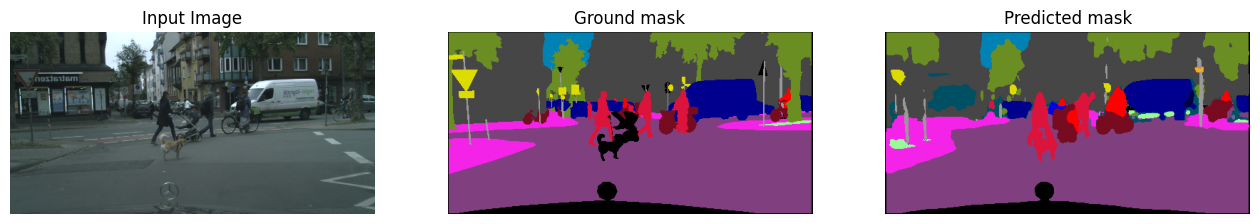

In [28]:

sample=6
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
# plt.savefig('result.png',bbox_inches='tight')